## Aim: Analyse the taiwanese company Bankruptcies(1999-2009)
## Objectives:
- Using finncial data from the Taiwan Economic Journal to build a model for predicting bankruptcy
- The data include 95 financial ratios and growth rates categories as:
1. Profitablity Ratio(eg. ROA, Operation Profit Margin)
2. Liquidity ratios(eg. Current Ratio, Quick Ratio)
3. Solvency Ratio(eg. Debt to Equity Ratio)
4. Efficiency Ratio (eg. Inventory Turnover, Asset Turnover)
5. Growth Ratio(eg. Sales Growth, Net Income Growth)



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings , gc
warnings.simplefilter("ignore")

## 2.Load Data

In [ ]:
df = pd.read_csv('/data.csv')

In [ ]:
df.head(2)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.40575,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.51673,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794


In [ ]:
df.shape

(6819, 96)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [ ]:
df['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis


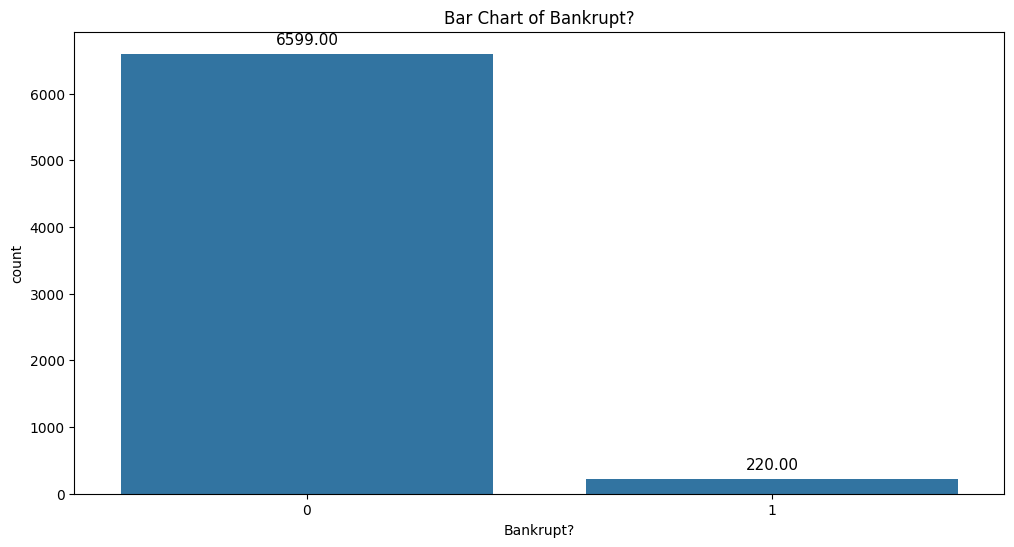

In [ ]:
# Bar chart of Bankrupt?

# Bar chart
plt.figure(figsize=(12, 6))
bar_plot = sns.countplot(x=df['Bankrupt?'])

plt.title('Bar Chart of Bankrupt?')

# Adding data labels
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center',
                      va = 'center',
                      fontsize = 11,
                      xytext = (0, 10),
                      textcoords = 'offset points')

plt.show()

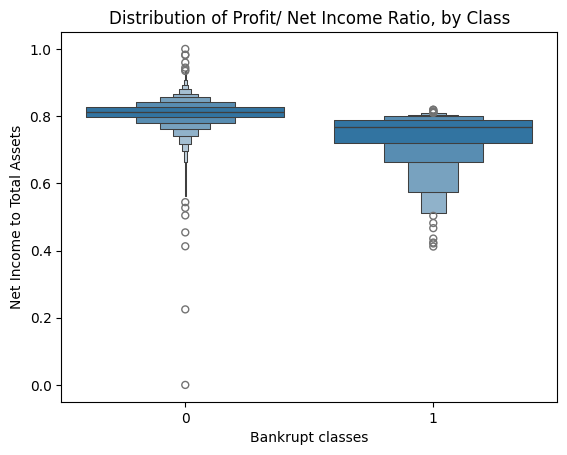

In [ ]:
#Plot net income to total assets by classes
sns.boxenplot(x="Bankrupt?" , y=" Net Income to Total Assets" , data=df)
plt.xlabel("Bankrupt classes")
plt.ylabel("Net Income to Total Assets")
plt.title("Distribution of Profit/ Net Income Ratio, by Class");

### Insights
1. The distribution of net income to total assets is higher for non-bankrupt companies than bankrupt companies.
2. There is a larger spread in net income to total assets for bankrupt companies than non-bankrupt companies.
3. Non-bankrupt companies have a higher median net income to total assets than bankrupt companies.

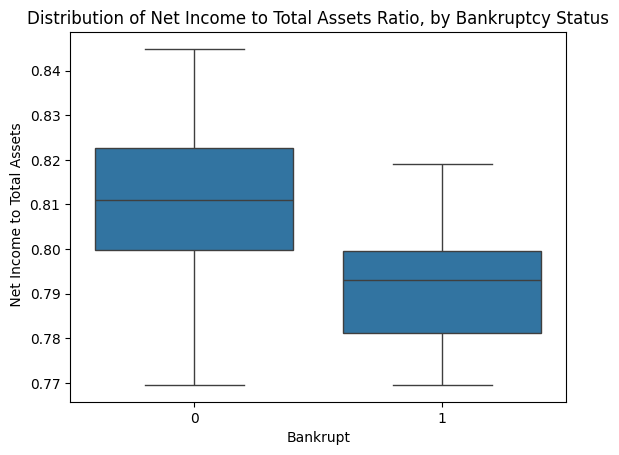

In [ ]:
#Only show parts with most distribution
q1 , q9 = df[' Net Income to Total Assets'].quantile([0.1,0.9])
mask = df[" Net Income to Total Assets"].between(q1 , q9)
sns.boxplot(x='Bankrupt?' , y=' Net Income to Total Assets', data= df[mask])
plt.xlabel("Bankrupt")
plt.ylabel(" Net Income to Total Assets")
plt.title("Distribution of Net Income to Total Assets Ratio, by Bankruptcy Status");

In [ ]:
# Identify the features that have the highest correlation with Bankrupt?

# Compute the correlation matrix
correlation_matrix = df.corr()

# Get the correlation of 'Bankrupt?' with other features
correlation_with_bankrupt = correlation_matrix['Bankrupt?']

# Get absolute values of correlation for comparison
absolute_correlation_with_bankrupt = correlation_with_bankrupt.abs()

# Get the twenty features that have the highest correlation with 'Bankrupt?'
top_20_correlated_features = absolute_correlation_with_bankrupt.nlargest(21).drop('Bankrupt?', errors='ignore')

print(top_20_correlated_features)

 Net Income to Total Assets                                 0.315457
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 ROA(C) before interest and depreciation before interest    0.260807
 Net worth/Assets                                           0.250161
 Debt ratio %                                               0.250161
 Persistent EPS in the Last Four Seasons                    0.219560
 Retained Earnings to Total Assets                          0.217779
 Net profit before tax/Paid-in capital                      0.207857
 Per Share Net profit before tax (Yuan ¥)                   0.201395
 Current Liability to Assets                                0.194494
 Working Capital to Total Assets                            0.193083
 Net Income to Stockholder's Equity                         0.180987
 Borrowing dependency                                       0.176543
 Current Liability to Current Asse

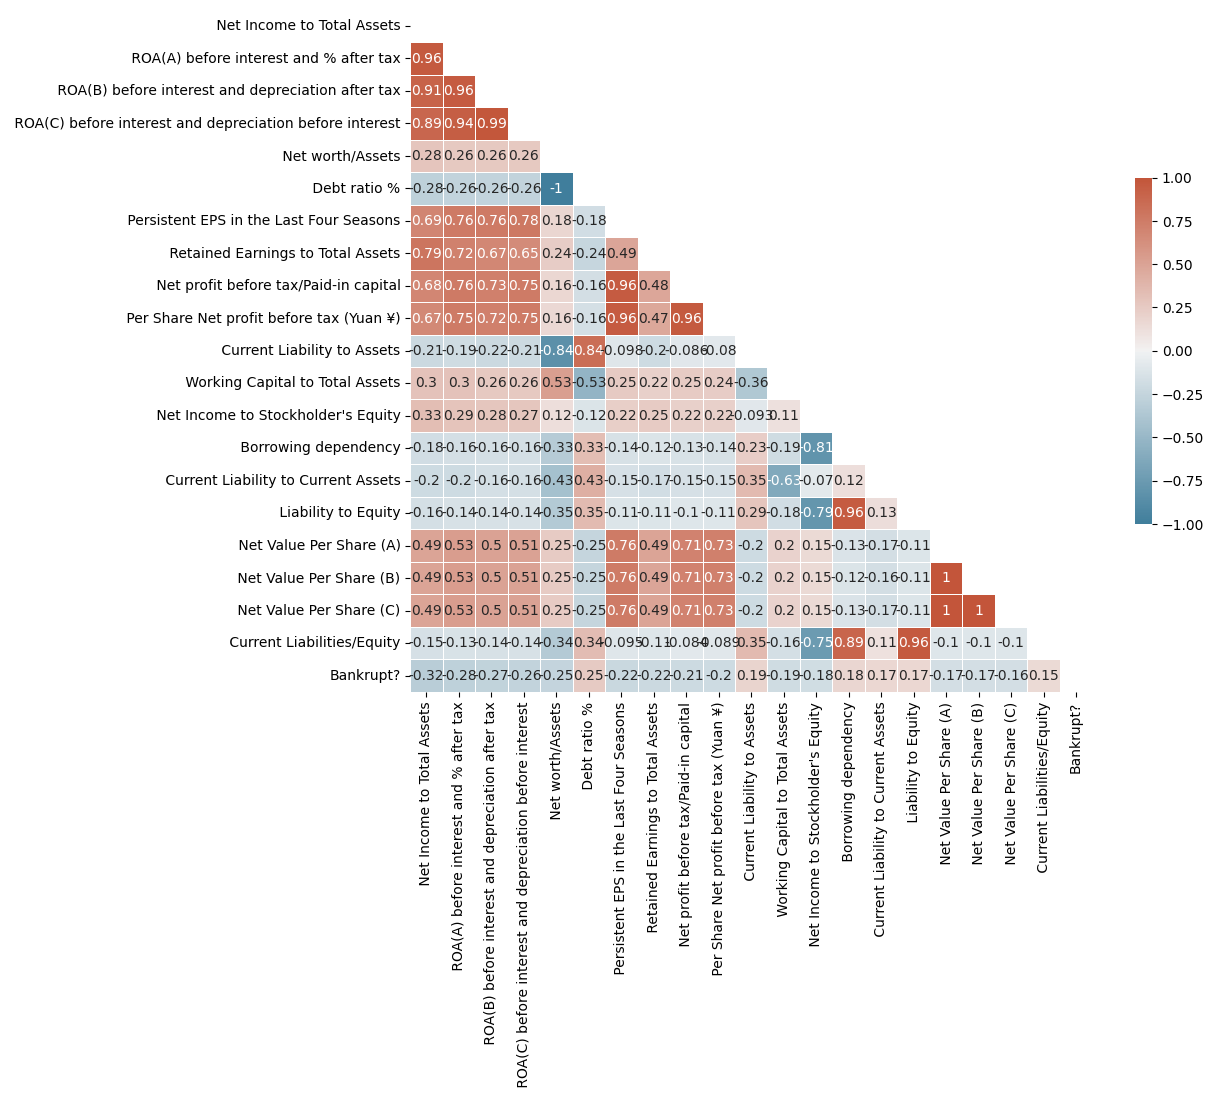

In [ ]:
# Plot the heatmap
features_list = list(top_20_correlated_features.index) + ['Bankrupt?']

# Construct a DataFrame with wanted features only
df_subset = df[features_list]

# Compute the correlation matrix for the subset dataframe
correlation_matrix_subset = df_subset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_subset, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_subset, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Multicolinearity

In [ ]:
# To avoid multi-colinearity, we identify the highly correlated features in df

# Calculate correlation matrix
corr_matrix = df.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Identify pairs with correlation above 0.95
pairs = [(column, row) for column in upper.columns for row in upper.index if abs(upper[column][row]) > 0.95]
# Prepare a list containing column pairs and their correlation
output = [(pair[0], pair[1], upper[pair[0]][pair[1]]) for pair in pairs]
# Create a DataFrame from the list
df_output = pd.DataFrame(output, columns=['Feature1', 'Feature2', 'Correlation'])
# Set pandas to display all columns in DataFrame
pd.set_option('display.expand_frame_repr', False)
# Print the output DataFrame
df_output

,Feature1,Feature2,Correlation
0,ROA(B) before interest and depreciation after...,ROA(C) before interest and depreciation befor...,0.986849
1,ROA(B) before interest and depreciation after...,ROA(A) before interest and % after tax,0.955741
2,Realized Sales Gross Margin,Operating Gross Margin,0.999518
3,After-tax net Interest Rate,Pre-tax net Interest Rate,0.986379
4,Continuous interest rate (after tax),Pre-tax net Interest Rate,0.993617
5,Continuous interest rate (after tax),After-tax net Interest Rate,0.984452
6,Net Value Per Share (A),Net Value Per Share (B),0.999342
7,Net Value Per Share (C),Net Value Per Share (B),0.999179
8,Net Value Per Share (C),Net Value Per Share (A),0.999837
9,Per Share Net profit before tax (Yuan ¥),Persistent EPS in the Last Four Seasons,0.955591


In [ ]:
# Drop features to avoid multi-colinearity
# Set the columns we want to drop
columns_to_drop = list(df_output['Feature2'])

# Drop the columns
df = df.drop(columns_to_drop, axis=1)

In [ ]:
# Identify the features that have the hgihest correlation with Bankrupt?

# Compute the correlation matrix
correlation_matrix = df.corr()

# Get the correlation of 'Bankrupt?' with other features
correlation_with_bankrupt = correlation_matrix['Bankrupt?']

# Get absolute values of correlation for comparison
absolute_correlation_with_bankrupt = correlation_with_bankrupt.abs()

# Get the twenty features that have the highest correlation with 'Bankrupt?'
top_20_correlated_features = absolute_correlation_with_bankrupt.nlargest(21).drop('Bankrupt?', errors='ignore')

print(top_20_correlated_features)

 Net Income to Total Assets                           0.315457
 ROA(B) before interest and depreciation after tax    0.273051
 Net worth/Assets                                     0.250161
 Retained Earnings to Total Assets                    0.217779
 Net profit before tax/Paid-in capital                0.207857
 Current Liability to Assets                          0.194494
 Working Capital to Total Assets                      0.193083
 Net Income to Stockholder's Equity                   0.180987
 Current Liability to Current Assets                  0.171306
 Liability to Equity                                  0.166812
 Net Value Per Share (C)                              0.164784
 Working Capital/Equity                               0.147221
 Operating profit/Paid-in capital                     0.141111
 Liability-Assets Flag                                0.139212
 Total expense/Assets                                 0.139049
 Equity to Long-term Liability                        0

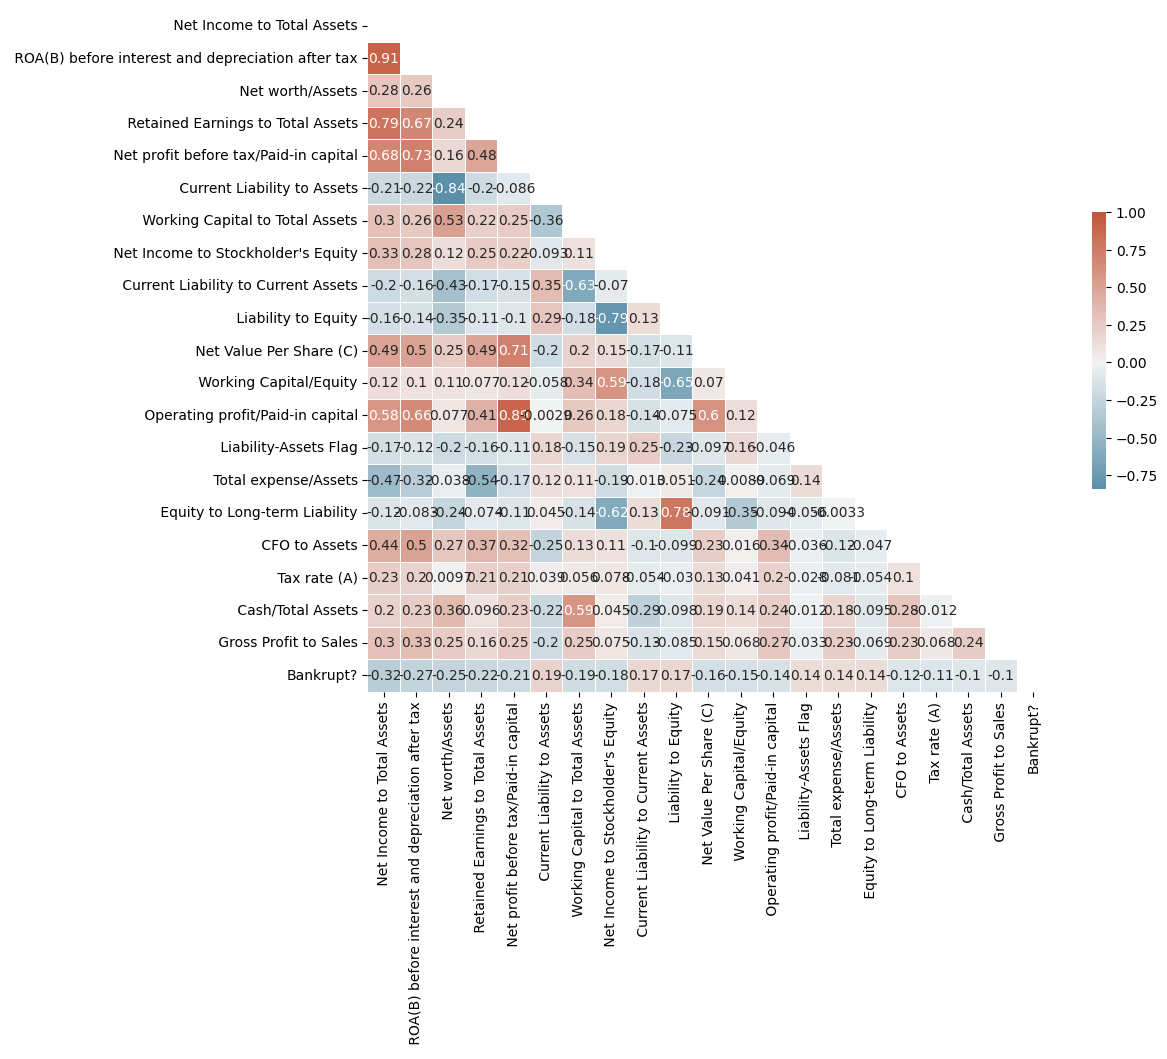

In [ ]:
# Plot the heatmap
features_list = list(top_20_correlated_features.index) + ['Bankrupt?']

# Construct a DataFrame with wanted features only
df_subset = df[features_list]

# Compute the correlation matrix for the subset dataframe
correlation_matrix_subset = df_subset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_subset, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_subset, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .4}, annot=True)
plt.show()

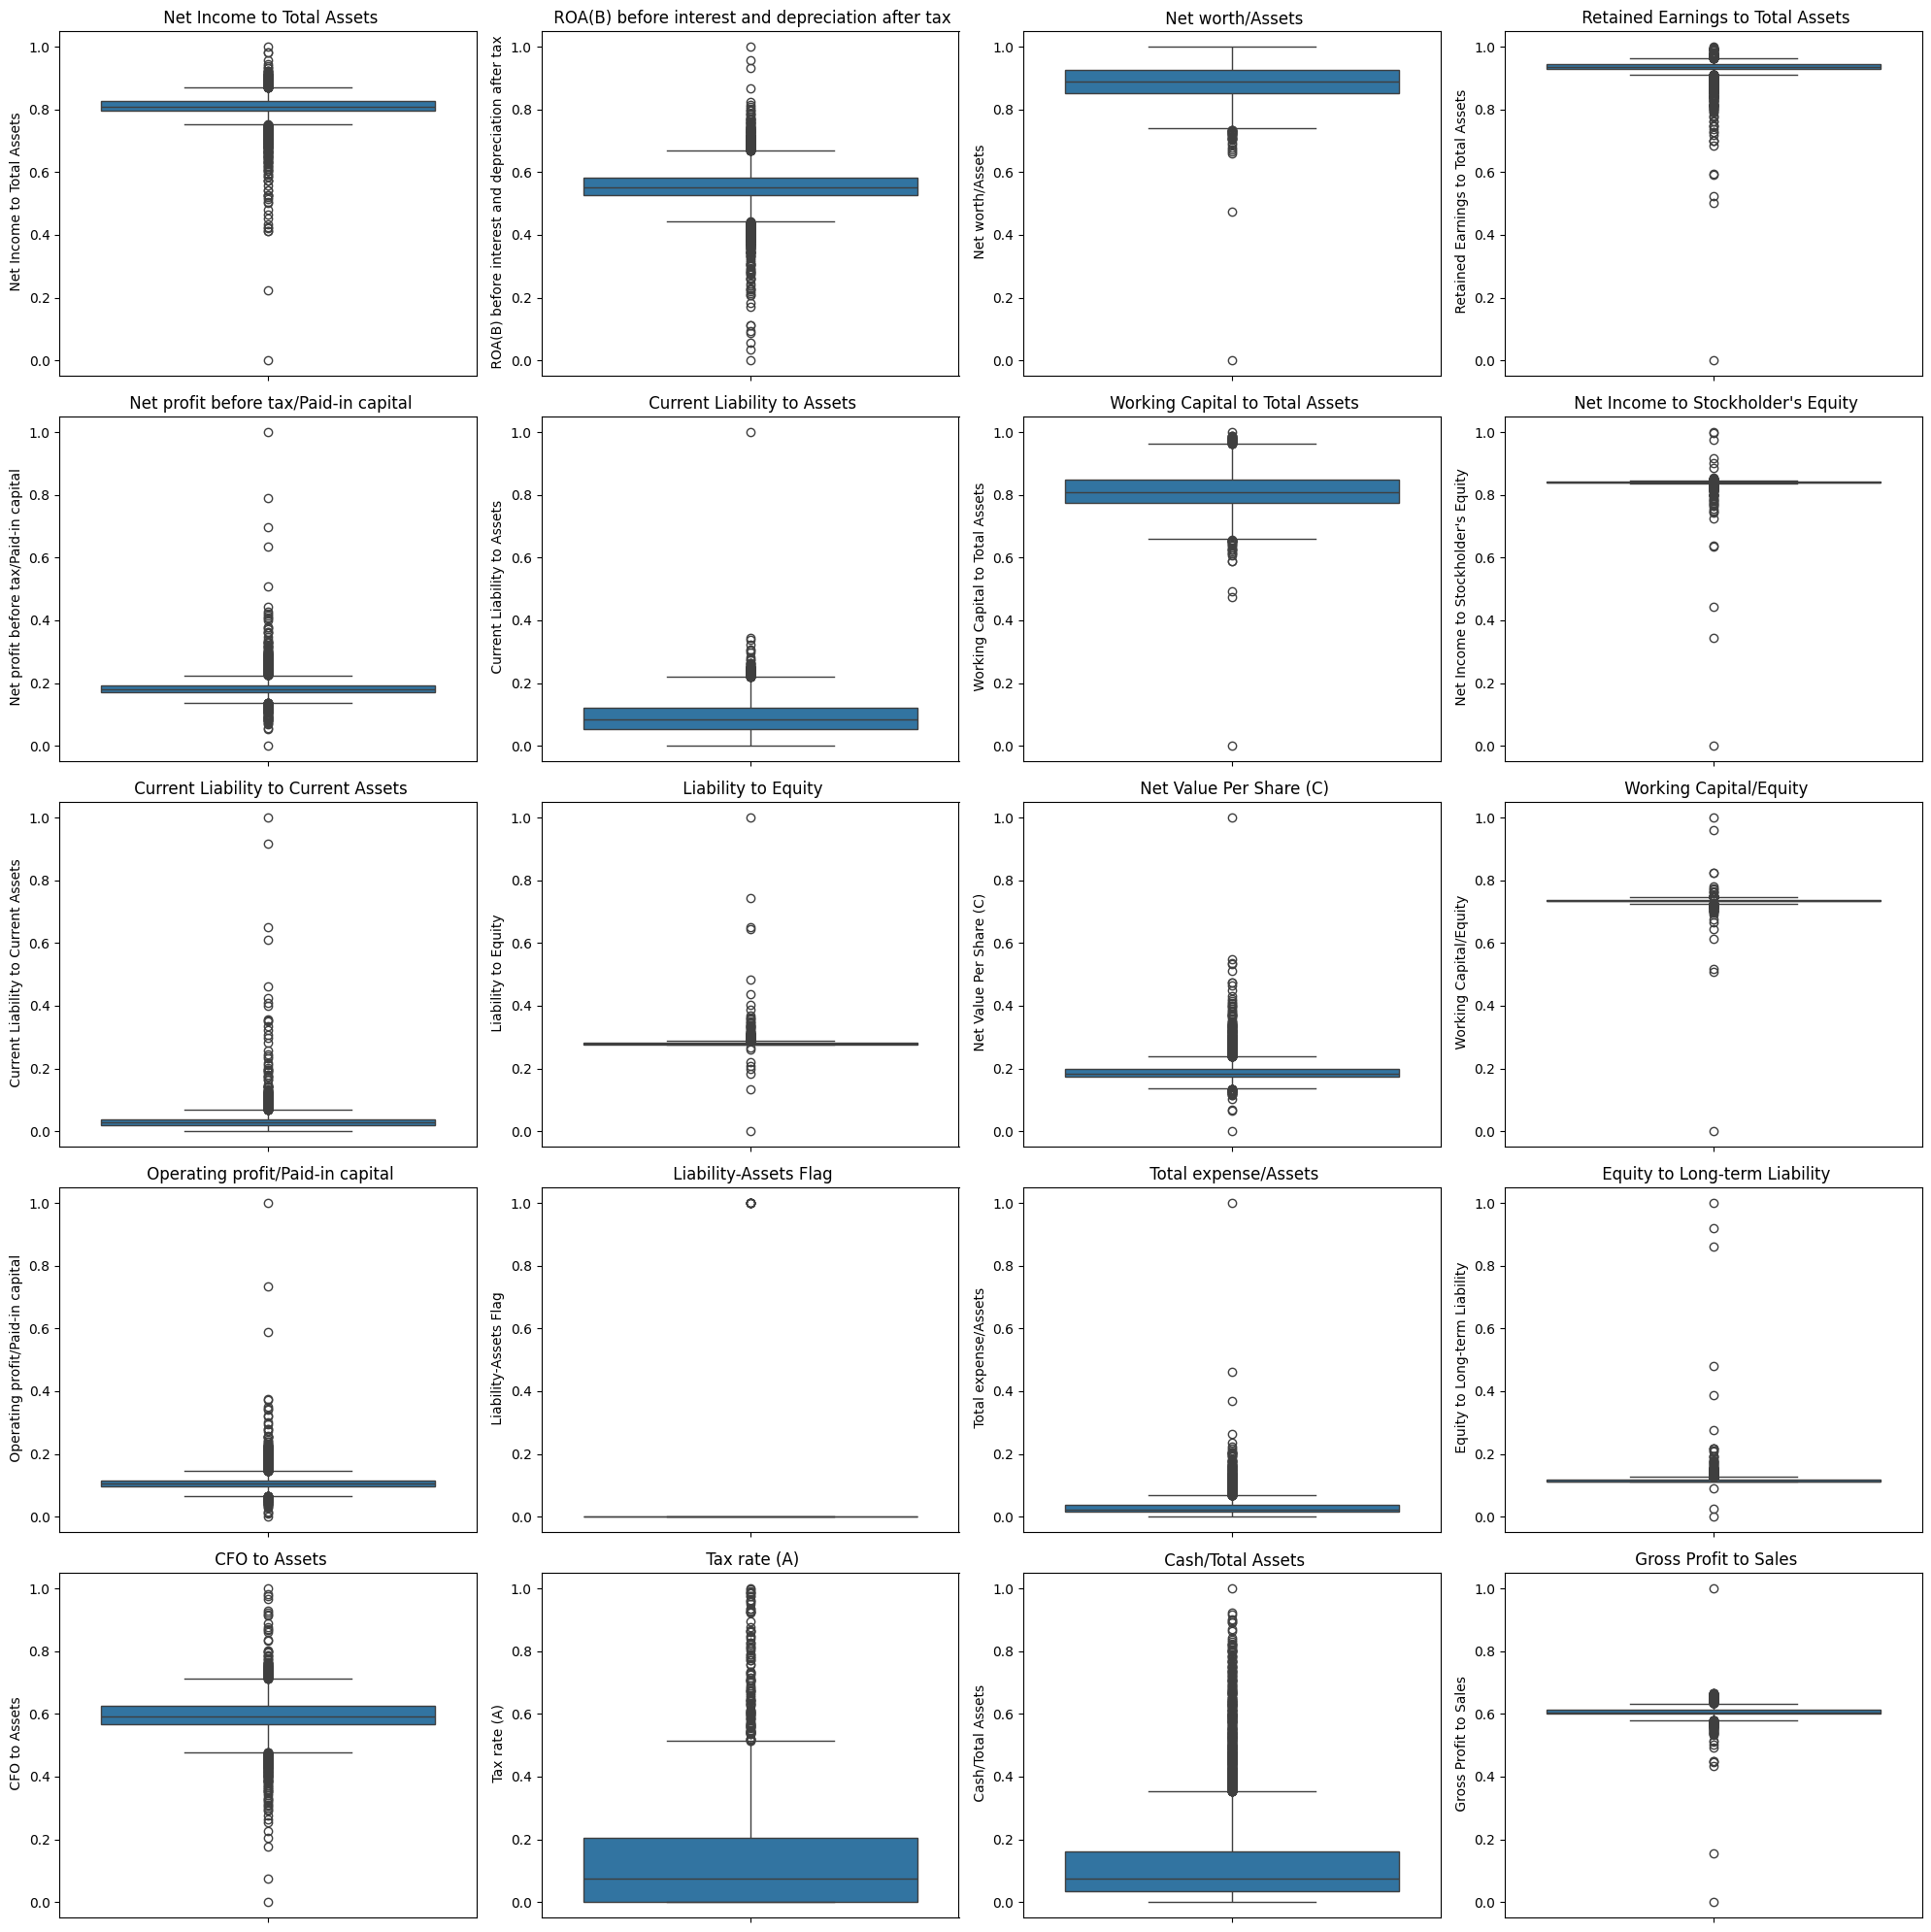

In [ ]:
# Plot the boxplots

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

# assuming that top_ten_correlated_features index contains feature names
features = top_20_correlated_features.index

for i, feature in enumerate(features):
    # calculate row and column index
    row = i // 4
    col = i % 4

    # plot boxplot on corresponding subplot
    sns.boxplot(df[feature], ax=axs[row, col])
    axs[row, col].set_title(feature)

plt.tight_layout()
plt.show()

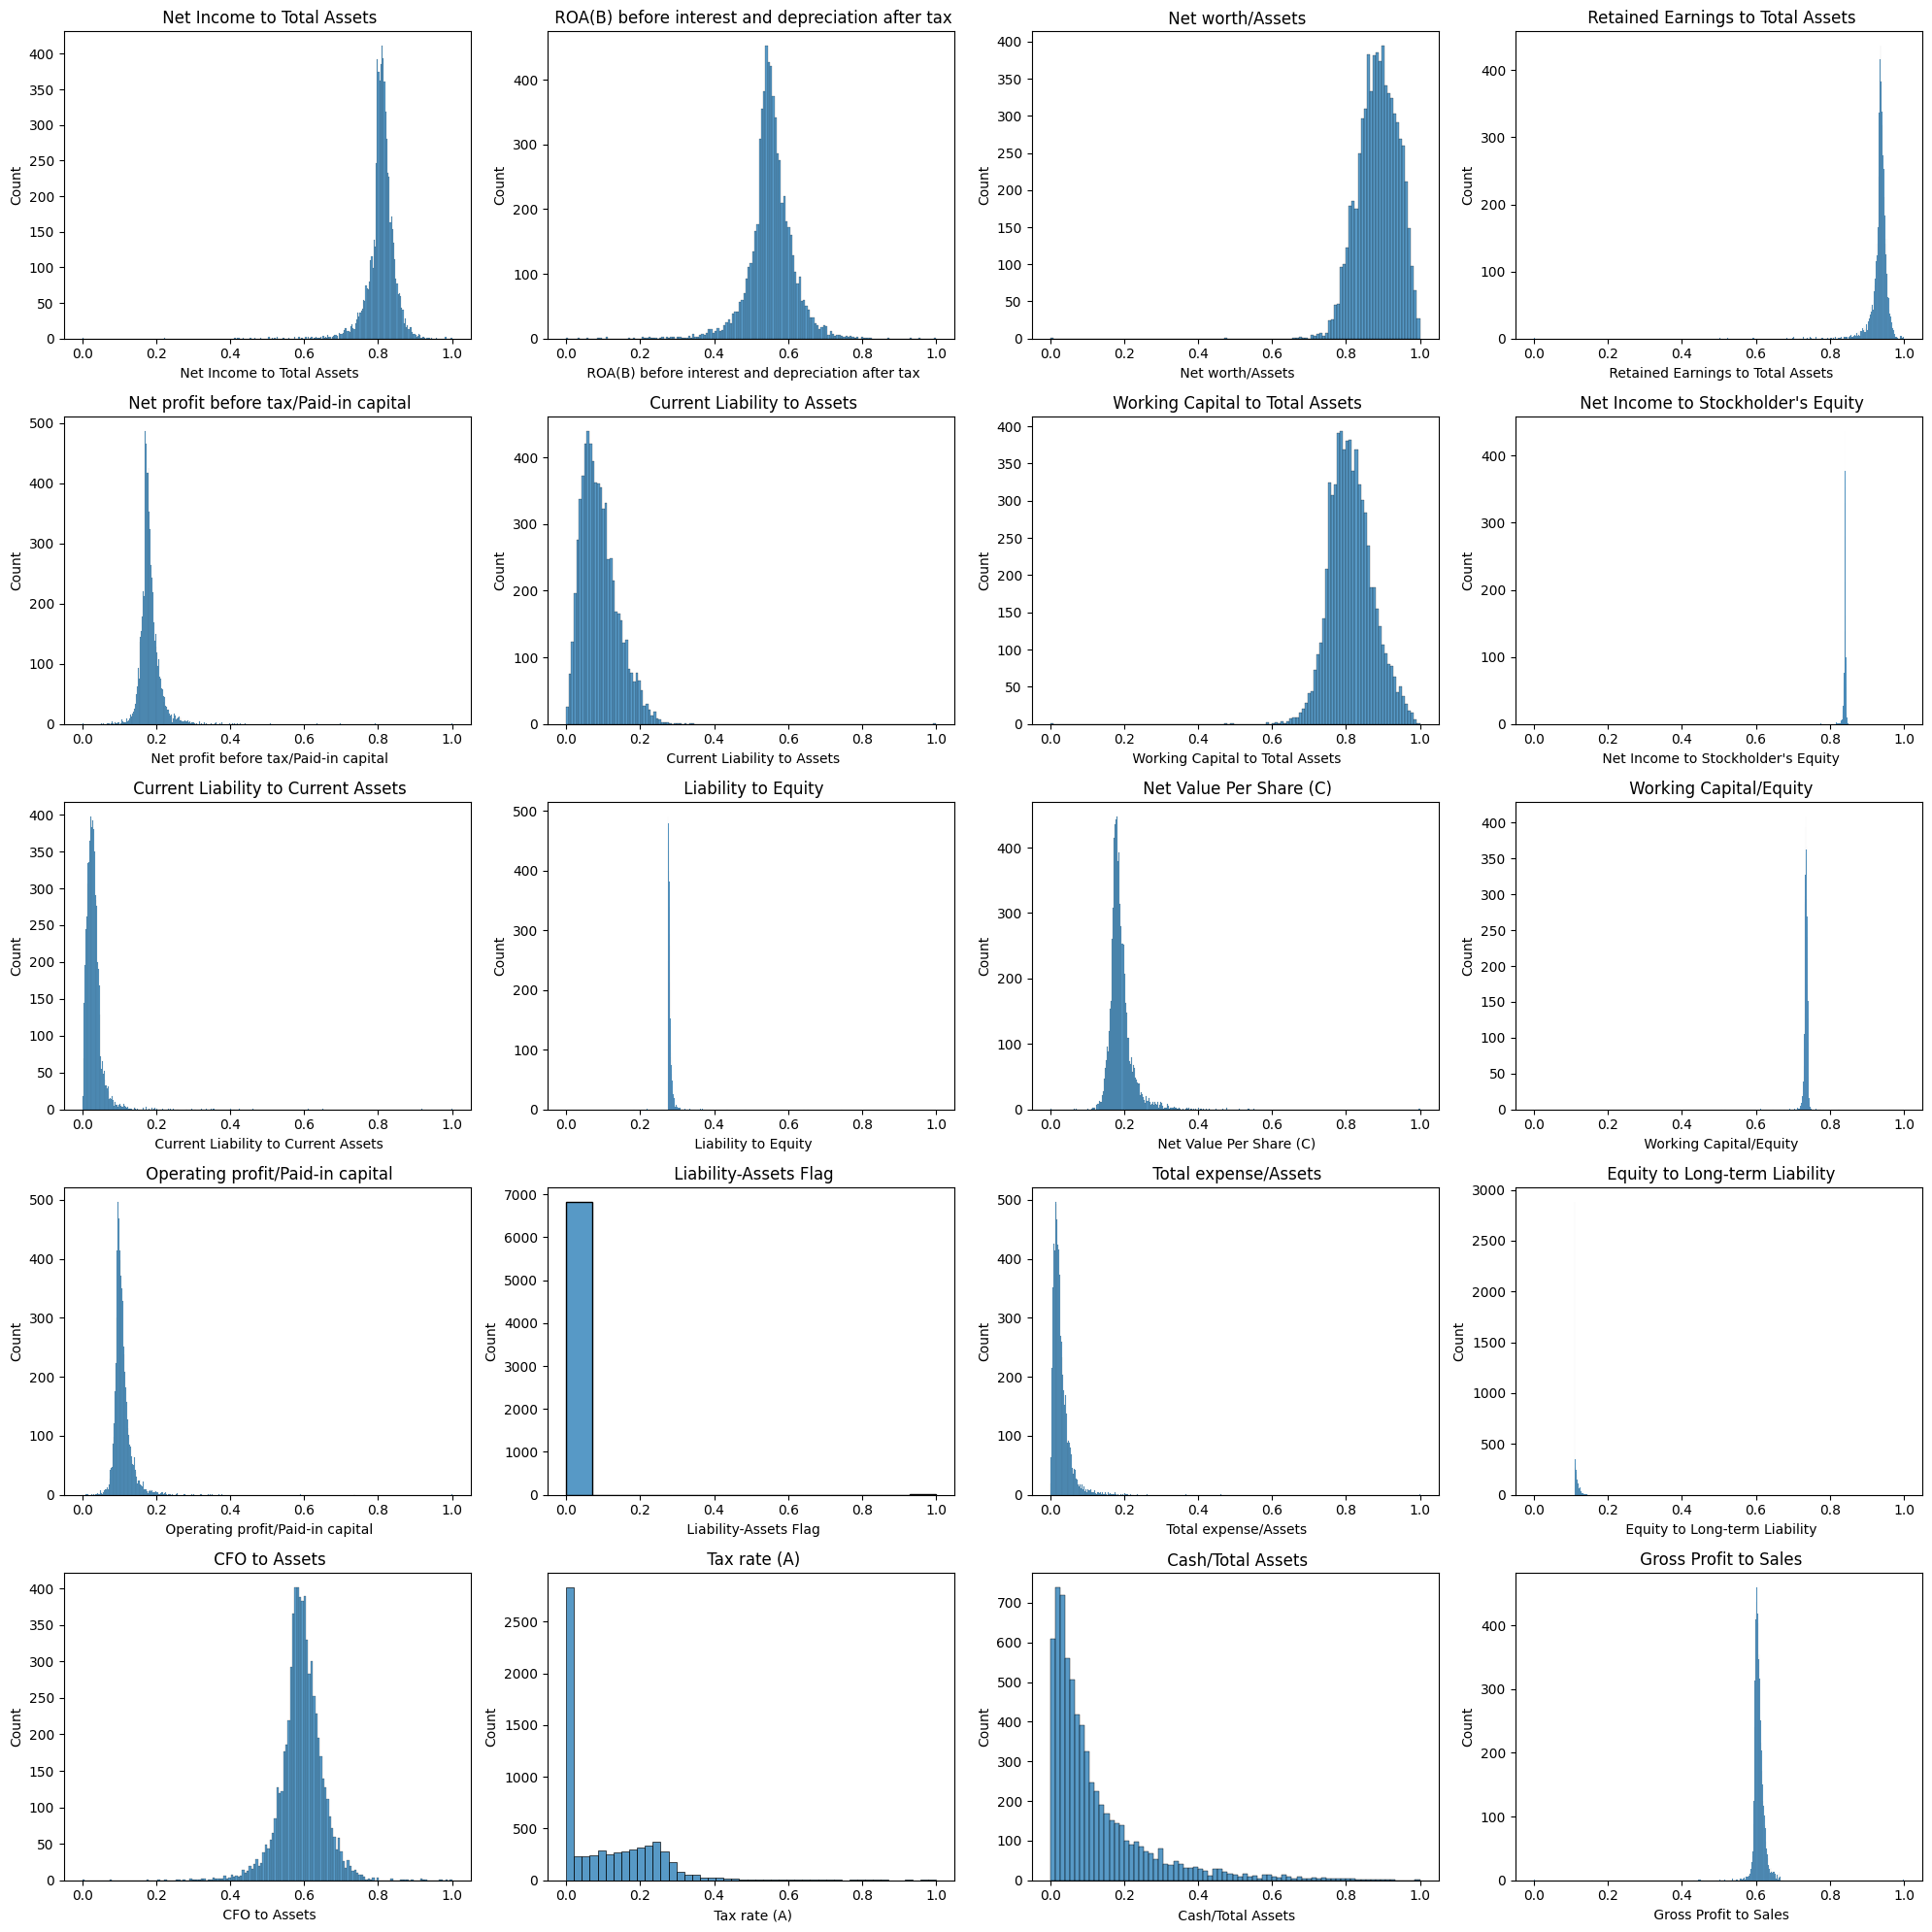

In [ ]:
# Plot the distribution plots of top_ten_correlated_features
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

# assuming that top_ten_correlated_features index contains feature names
features = top_20_correlated_features.index

for i, feature in enumerate(features):
     # calculate row and column index
    row = i // 4
    col = i % 4

    # plot distribution on corresponding subplot
    sns.histplot(df[feature], ax=axs[row, col])
    axs[row, col].set_title(feature)

plt.tight_layout()
plt.show()

## 4. Preprocessing

In [ ]:
# Split features and target
target = "Bankrupt?"
X = df.drop(columns=[target])
y = df[target]

# Split train and test set
from sklearn.model_selection import train_test_split , GridSearchCV
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [ ]:
# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform validation data
X_val_scaled = scaler.transform(X_test)  # Note we only 'transform' the validation set, not 'fit_transform'
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Fit and resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Now you can proceed with your training using: X_train_smote, y_train_smote, X_val_scaled and y_test

## 5. Machine Learning Models

### 5.1 Logestic Regression

In [ ]:
# Build model
logreg = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator= logreg, param_grid = param_grid, cv=3)

grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print('Best parameters:', best_params)
print('Best accuracy score (on the training dataset):', best_score)

# Use the best estimator to make predictions on the validation set
brf_model = grid_search.best_estimator_
y_pred = brf_model.predict(X_val_scaled)


# Calculate accuracy, precision, recall, and F1 score
accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy1)
print('Precision: ', precision1)
print('Recall: ', recall1)
print('F1 Score: ', f1_1)

Best parameters: {'C': 100, 'solver': 'liblinear'}
Best accuracy score (on the training dataset): 0.9027620128641695
Accuracy:  0.8702346041055719
Precision:  0.18181818181818182
Recall:  0.7058823529411765
F1 Score:  0.28915662650602414


roc score:  0.9152367725460329


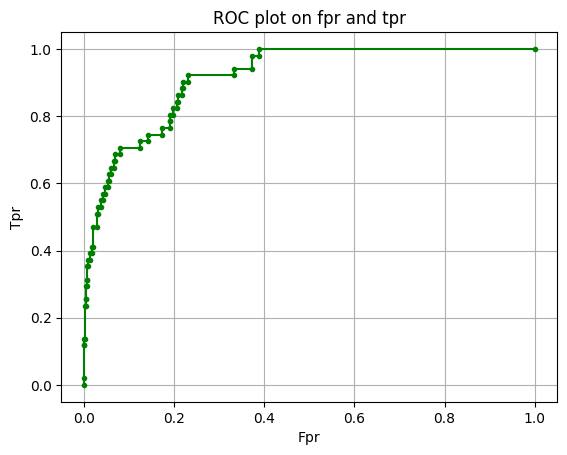

In [ ]:
pred_prob_test= brf_model.predict_proba(X_val_scaled)
roc_score1 = roc_auc_score(y_test,pred_prob_test[:,1])
print('roc score: ', roc_score1)
fpr,tpr,thre =roc_curve(y_test,pred_prob_test[:,1])

#roc curve plot
plt.plot(fpr,tpr,marker='.',color='green')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title("ROC plot on fpr and tpr")
plt.grid()

<Axes: >

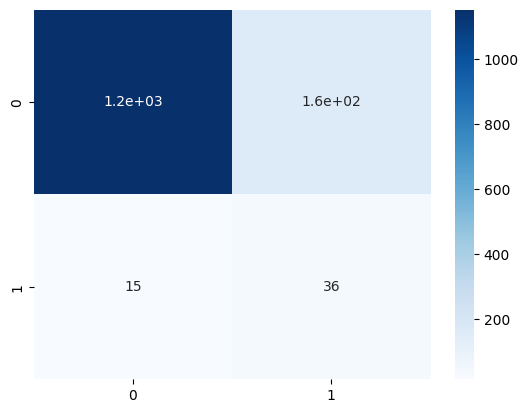

In [ ]:
confusion_matrix1 = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix1, annot=True, cmap='Blues')

In [ ]:
# Evaluate using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1313
           1       0.18      0.71      0.29        51

    accuracy                           0.87      1364
   macro avg       0.58      0.79      0.61      1364
weighted avg       0.96      0.87      0.90      1364



### 5.2 KNN

In [ ]:
# Build model
knn = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': range(1, 21),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=knn, param_grid = param_grid, cv=3)

grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print('Best parameters:', best_params)
print('Best accuracy score (on the training dataset):', best_score)

# Use the best estimator to make predictions on the validation set
brf_model = grid_search.best_estimator_
y_pred = brf_model.predict(X_val_scaled)


# Calculate accuracy, precision, recall, and F1 score
accuracy2 = accuracy_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred)
recall2 = recall_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy2)
print('Precision: ', precision2)
print('Recall: ', recall2)
print('F1 Score: ', f1_2)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}
Best accuracy score (on the training dataset): 0.9746500189178963
Accuracy:  0.9435483870967742
Precision:  0.3333333333333333
Recall:  0.5098039215686274
F1 Score:  0.40310077519379844


roc score:  0.7894359571703776


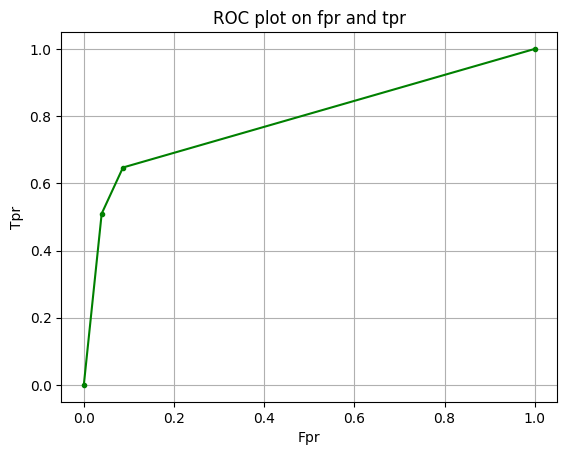

In [ ]:
pred_prob_test= brf_model.predict_proba(X_val_scaled)
roc_score2 = roc_auc_score(y_test,pred_prob_test[:,1])
print('roc score: ', roc_score2)
fpr,tpr,thre =roc_curve(y_test,pred_prob_test[:,1])

# roc curve plot
plt.plot(fpr,tpr,marker='.',color='green')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title("ROC plot on fpr and tpr")
plt.grid()

<Axes: >

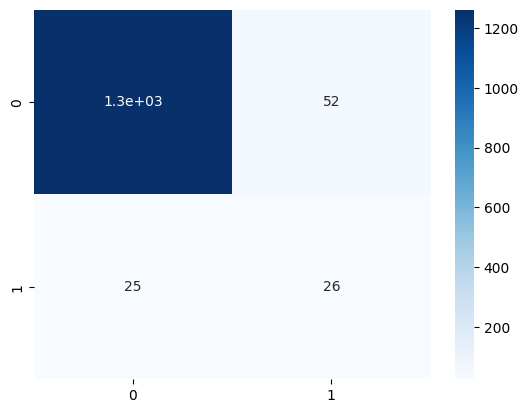

In [ ]:
confusion_matrix2 = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix2, annot=True, cmap='Blues')

In [ ]:
# Evaluate using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.33      0.51      0.40        51

    accuracy                           0.94      1364
   macro avg       0.66      0.74      0.69      1364
weighted avg       0.96      0.94      0.95      1364



### 5.3 Decision Tree

In [ ]:
# Build model
dt = DecisionTreeClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'criterion': ['gini', 'entropy']
}
# Initialize the grid search model
grid_search = GridSearchCV(dt, param_grid = param_grid, cv=3)

grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print('Best parameters:', best_params)
print('Best accuracy score (on the training dataset):', best_score)

# Use the best estimator to make predictions on the validation set
brf_model = grid_search.best_estimator_
y_pred = brf_model.predict(X_val_scaled)


# Calculate accuracy, precision, recall, and F1 score
accuracy3 = accuracy_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred)
recall3 = recall_score(y_test, y_pred)
f1_3 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy3)
print('Precision: ', precision3)
print('Recall: ', recall3)
print('F1 Score: ', f1_3)

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best accuracy score (on the training dataset): 0.9426787741203179
Accuracy:  0.8988269794721407
Precision:  0.20408163265306123
Recall:  0.5882352941176471
F1 Score:  0.30303030303030304


roc score:  0.754603288383137


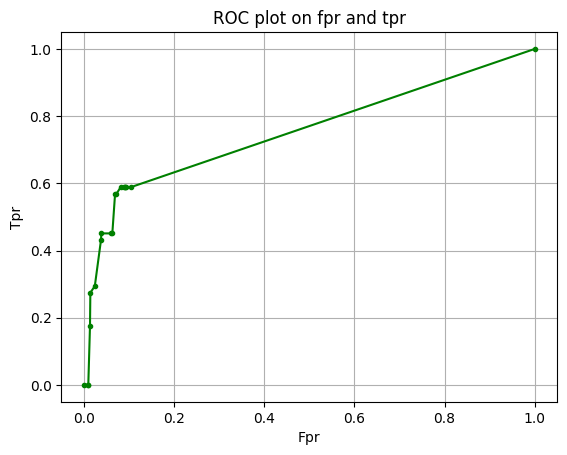

In [ ]:
pred_prob_test= brf_model.predict_proba(X_val_scaled)
roc_score3 = roc_auc_score(y_test,pred_prob_test[:,1])
print('roc score: ', roc_score3)
fpr,tpr,thre =roc_curve(y_test,pred_prob_test[:,1])

# roc curve plot
plt.plot(fpr,tpr,marker='.',color='green')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title("ROC plot on fpr and tpr")
plt.grid()

<Axes: >

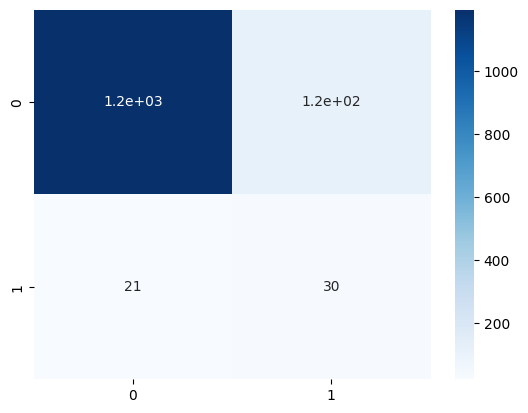

In [ ]:
confusion_matrix3 = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix3, annot=True, cmap='Blues')

In [ ]:
# Evaluate using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1313
           1       0.20      0.59      0.30        51

    accuracy                           0.90      1364
   macro avg       0.59      0.75      0.62      1364
weighted avg       0.95      0.90      0.92      1364



### 5.4 Random Forest

In [ ]:
# Build model
rfc = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_dist = {'n_estimators': [100, 200, 500, 1000],
              'max_depth': [3, 5, 7, 9]}

rand_search = RandomizedSearchCV(rfc,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5,
                                 random_state=42)

# Initialize the grid search model
rand_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and best accuracy score
best_params = rand_search.best_params_
best_score = rand_search.best_score_

In [ ]:
print('Best parameters:', best_params)
print('Best accuracy score (on the training dataset):', best_score)

# Use the best estimator to make predictions on the validation set
brf_model = rand_search.best_estimator_
y_pred = brf_model.predict(X_val_scaled)


# Calculate accuracy, precision, recall, and F1 score
accuracy4 = accuracy_score(y_test, y_pred)
precision4 = precision_score(y_test, y_pred)
recall4 = recall_score(y_test, y_pred)
f1_4 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy4)
print('Precision: ', precision4)
print('Recall: ', recall4)
print('F1 Score: ', f1_4)

Best parameters: {'n_estimators': 500, 'max_depth': 9}
Best accuracy score (on the training dataset): 0.9658534905202512
Accuracy:  0.9325513196480938
Precision:  0.3247863247863248
Recall:  0.7450980392156863
F1 Score:  0.4523809523809524


roc score:  0.9321266968325792


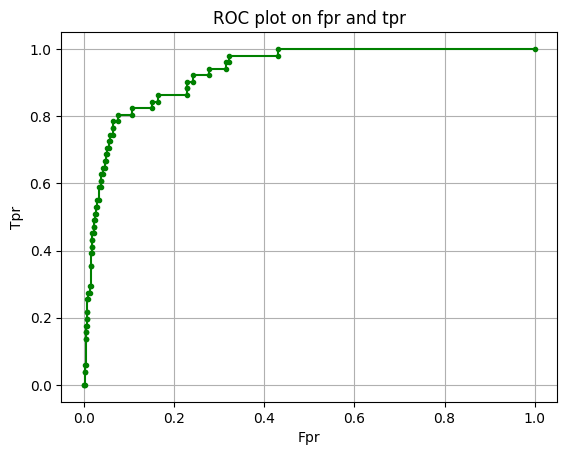

In [ ]:
pred_prob_test= brf_model.predict_proba(X_val_scaled)
roc_score4 = roc_auc_score(y_test,pred_prob_test[:,1])
print('roc score: ', roc_score4)
fpr,tpr,thre =roc_curve(y_test,pred_prob_test[:,1])

# roc curve plot
plt.plot(fpr,tpr,marker='.',color='green')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title("ROC plot on fpr and tpr")
plt.grid()

<Axes: >

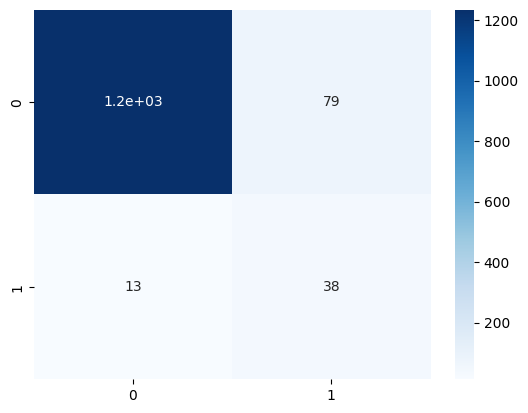

In [ ]:
confusion_matrix4 = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix4, annot=True, cmap='Blues')

In [ ]:
# Evaluate using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1313
           1       0.32      0.75      0.45        51

    accuracy                           0.93      1364
   macro avg       0.66      0.84      0.71      1364
weighted avg       0.96      0.93      0.94      1364



### 5.5 Adaboost

In [ ]:
# Define the base decision tree classifier
adaboost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
# Define the parameter distributions for hyperparameter tuning
param_distributions = {
    'n_estimators': [50, 100, 200],  # Integer distribution for boosting stages
    'learning_rate': np.random.rand(10),  # Uniform distribution for learning rate (0 to 1)
    'base_estimator__max_depth': [1, 5, 10]  # List of values for max depth of decision trees
}

# Create the RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=adaboost,  # Use adaboost here
                                 param_distributions=param_distributions,
                                 n_iter=5,  # Number of random parameter sets to try
                                 cv=5,    # Number of cross-validation folds
                                 random_state=42)

# Fit the model to the training data
rand_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters and best score
best_params = rand_search.best_params_
best_score = rand_search.best_score_

In [ ]:
print('Best parameters:', best_params)
print('Best accuracy score (on the training dataset):', best_score)

# Use the best estimator to make predictions on the validation set
brf_model = rand_search.best_estimator_
y_pred = brf_model.predict(X_val_scaled)


# Calculate accuracy, precision, recall, and F1 score
accuracy5 = accuracy_score(y_test, y_pred)
precision5 = precision_score(y_test, y_pred)
recall5 = recall_score(y_test, y_pred)
f1_5 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy5)
print('Precision: ', precision5)
print('Recall: ', recall5)
print('F1 Score: ', f1_5)

Best parameters: {'n_estimators': 100, 'learning_rate': 0.3004232480724228, 'base_estimator__max_depth': 5}
Best accuracy score (on the training dataset): 0.9871362144970712
Accuracy:  0.9567448680351907
Precision:  0.4166666666666667
Recall:  0.39215686274509803
F1 Score:  0.40404040404040403


roc score:  0.8978689724176038


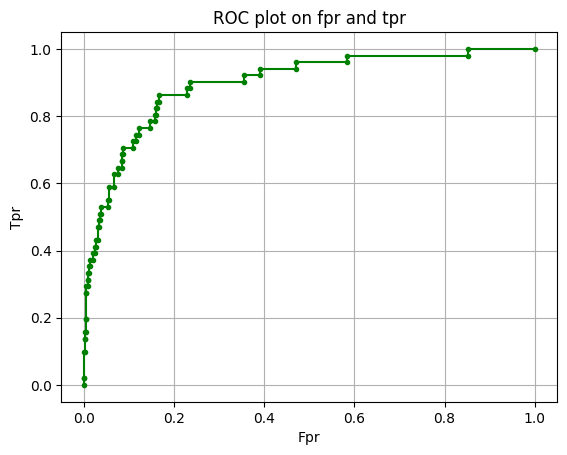

In [ ]:
pred_prob_test= brf_model.predict_proba(X_val_scaled)
roc_score5 = roc_auc_score(y_test,pred_prob_test[:,1])
print('roc score: ', roc_score5)
fpr,tpr,thre =roc_curve(y_test,pred_prob_test[:,1])

# roc curve plot
plt.plot(fpr,tpr,marker='.',color='green')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title("ROC plot on fpr and tpr")
plt.grid()

<Axes: >

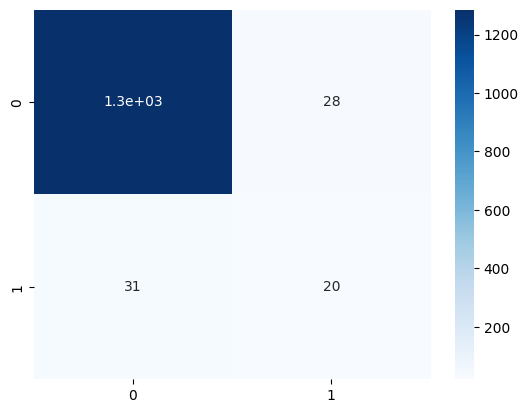

In [ ]:
confusion_matrix5 = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix5, annot=True, cmap='Blues')

In [ ]:
# Evaluate using classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1313
           1       0.42      0.39      0.40        51

    accuracy                           0.96      1364
   macro avg       0.70      0.69      0.69      1364
weighted avg       0.96      0.96      0.96      1364



## 6. Conclusion:
In conclusion, this project successfully built a model to predict company bankruptcies in Taiwan (1999-2009) using financial data from the Taiwan Economic Journal. The Random Forest algorithm achieved the highest accuracy among all models tested, reaching an impressive 93%.This suggests that the Random Forest effectively captured the complex relationships between various financial metrics and bankruptcy risk. However, it's important to acknowledge that the model's performance could potentially benefit from a more balanced dataset.